# LSTM neural network used to predict stock prices of Microsoft (MSFT)


### Imports and Data

In [1]:
#Basic imports and set-up

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Gathering the Data: 

#We will be using yfinance: 

import yfinance as yf
msft=yf.Ticker('MSFT')
msft_info=msft.history(period='max')
msft_info= msft_info.reset_index() #This is to make the date a column as well, so we can call it

In [2]:
#Basic imports and set-up

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Gathering the Data: 

#We will be using yfinance: 

import yfinance as yf
msft=yf.Ticker('MSFT')
msft_info=msft.history(period='max')
msft_info= msft_info.reset_index() #This is to make the date a column as well, so we can call it

In [9]:
#We will only be using 2 columns from this data frame: date and close. Let's create a data frame with just those 2 columns

msft_close=msft_info[['Date', 'Close']]
#msft_close.index=msft_close.pop('Date') #Make the date back to being the index of this new dataframe 

Text(0.5, 0, 'Year')

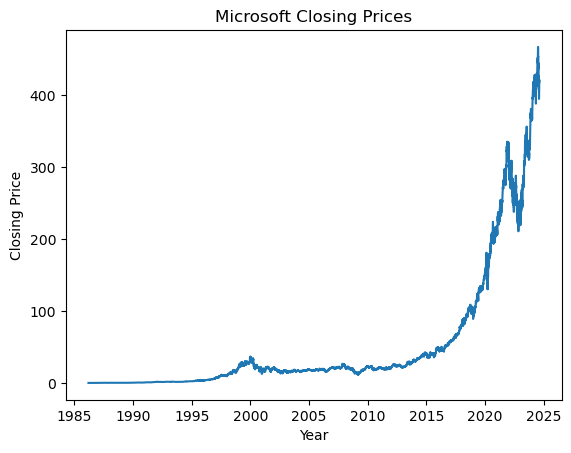

In [11]:
#We can visualize this dataframe now, using the matplotlib library 

plt.plot(msft_close['Date'], msft_close['Close'])
plt.title('Microsoft Closing Prices')
plt.ylabel('Closing Price')
plt.xlabel('Year')

In [13]:
# We need to create the labels, and because this is an LSTM, we have to go back and find what 
#the prices before the date we want the prices for can tells us about curent prices 

n=3 # default, this is the number of days prior that will inform the current closing price 

for i in range (1,n+1): 
    msft_close[f'Close_{i}_days_ago'] = msft_close['Close'].shift(i)

msft_close.dropna(inplace=True)

In [15]:
#Now, let's create separate dataframes for the date, the close price (which is the label) and the prior prices. 
#We also need to make them all arrays for our model, which is why we use the .values attribute of numpy 

#The dates array is useful to find the length of the array we need for our model 
dates = msft_close['Date'].values

#The y array holds all our data labels 
y = msft_close['Close'].values

#The X array holds all our close prices from the three days before for every date. We have to reshape it for the LSTM 
features = msft_close[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']].values
X = features.reshape(len(dates), features.shape[1], 1)

### Splitting, Making and Evaluating the Data

In [17]:
#Now we will use a train/validation/test split 

#Our training dataset will be 80% of our data: 
int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80]

#Our validation dataset will be 10% of our dataset (not used for training): 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]

#Our testing data will be the last 10% of the data we have left: 
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

In [19]:
# Now we will make our model

#We need to import some functions: 

from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import layers 

model=Sequential() 
model.add(layers.Input((3,1)))
model.add(layers.LSTM(64))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1)) #Output layer, regression task 
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mean_absolute_error'])

In [21]:
#Now, let's fit the model 

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 181.2065 - mean_absolute_error: 8.1606 - val_loss: 5679.3545 - val_mean_absolute_error: 60.5877
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.4728 - mean_absolute_error: 0.4177 - val_loss: 5349.6079 - val_mean_absolute_error: 57.8284
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.3975 - mean_absolute_error: 0.3754 - val_loss: 5264.2661 - val_mean_absolute_error: 56.7929
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.4175 - mean_absolute_error: 0.3982 - val_loss: 5352.1973 - val_mean_absolute_error: 57.1088
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.2952 - mean_absolute_error: 0.3153 - val_loss: 5422.9399 - val_mean_absolute_error: 57.0682
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.2951 - mean_absolute_error: 0.3306 - val_loss: 5553.3330 - val_mean_absolute_error: 57.6752
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - l

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


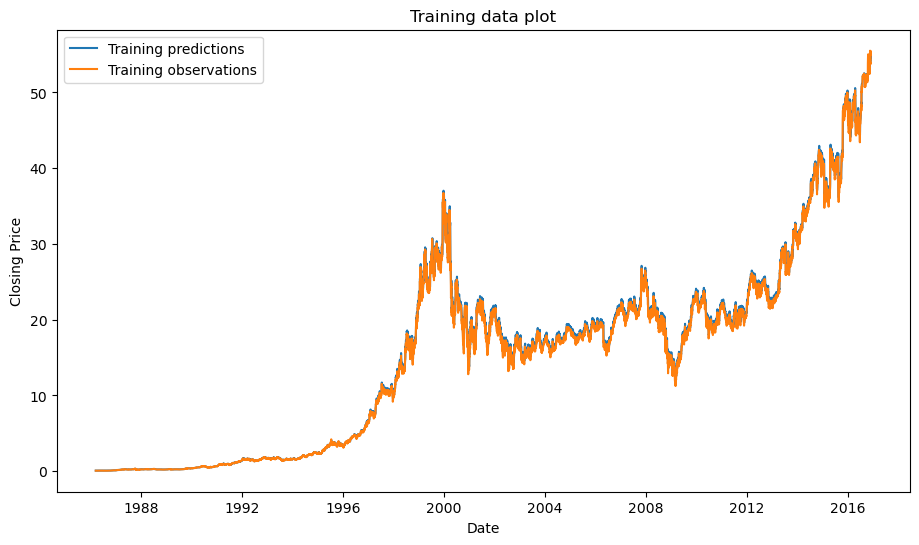

In [29]:
#Now, let's use the model to predict our data: 

#First, let's visualize this with the training data 

training_predictions=model.predict(X_train).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Training data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

#We can see that the lines for observations and predictions are almost overlapping. This makes sense, because our model has seen this data before

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step


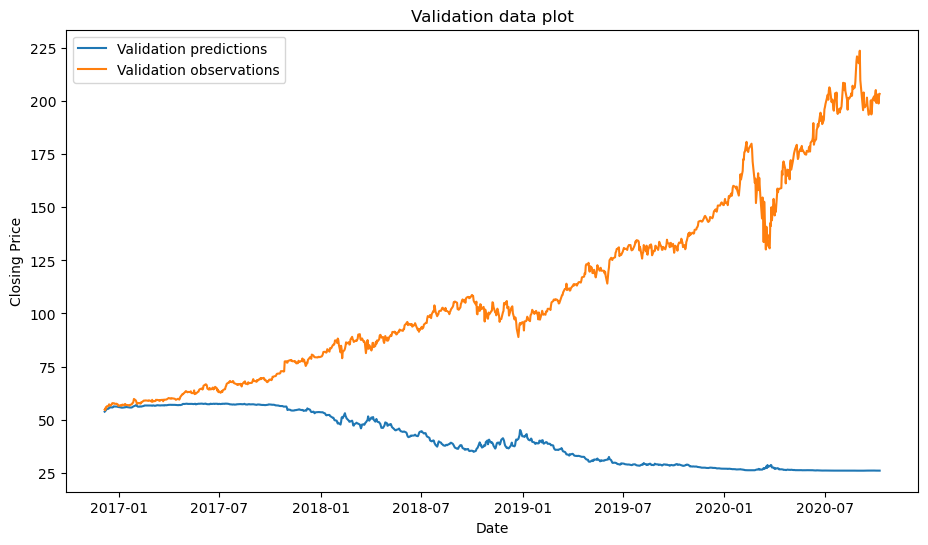

In [31]:
#Now let's do this with our validation data, which our model has NOT been fitted to 

validation_predictions=model.predict(X_val).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

# We can see that the predictions are far below the actual closing price observations. 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


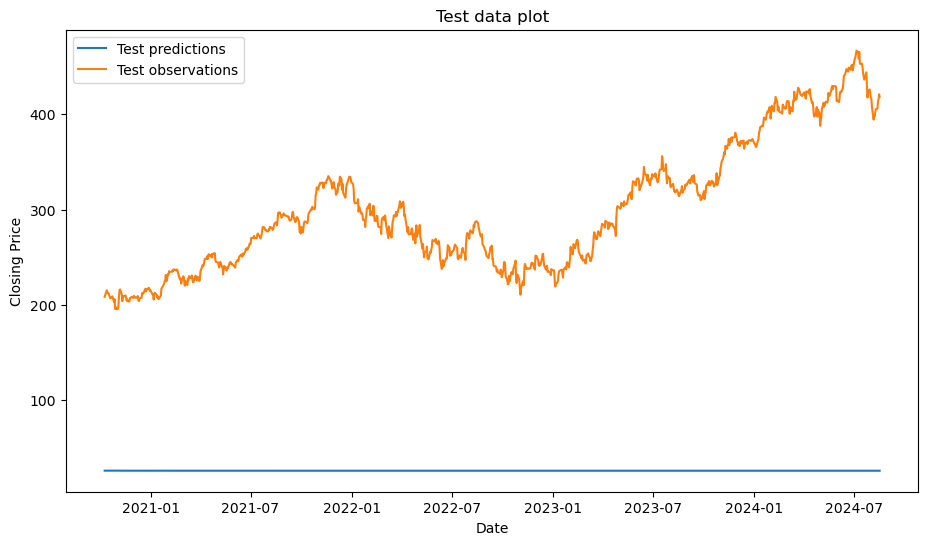

In [25]:
#Let's see how well the LSTM does on the test set 

test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])

#The model performs even worse. This is probably because the prices increase (seemingly) exponentially in the last 20% of the dataset. 
#Our training set does not include data from the last 20% of the overall dataset, which is why the model performs so poorly. 

### Making our model more accurate: using a shorter history for our model

In [33]:
#Instead, let's use a more recent date that is more representative of where our data is currently. 
#Let's use the date March 23, 2020 (arbitrarily). We have to change our dataset now to only include dates on and after that. 

cutoff_date = pd.Timestamp('2021-03-23').tz_localize('America/New_York') #Make sure my cutoff is the correct datatype 
msft_recent=msft_close[msft_close['Date']>=cutoff_date]


In [35]:
#We now need to make arrays again of our data 

#The dates array is useful to find the length of the array we need for our model and to visualize our results 
dates = msft_recent['Date'].values

#The y array holds all our data labels 
y = msft_recent['Close'].values

#The X array holds all our close prices from the three days before for every date. We have to reshape it for the LSTM 
features = msft_recent[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']].values
X = features.reshape(len(dates), features.shape[1], 1)

In [37]:
#We will now resplit our data based on this: (the code does not change, you just have to run it again) 

#Our training dataset will be 80% of our data: 
int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80]

#Our validation dataset will be 10% of our dataset (not used for training): 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]

#Our testing data will be the last 10% of the data we have left: 
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

In [39]:
#Let's run our model again (no code changes): 

model=Sequential() 
model.add(layers.Input((3,1)))
model.add(layers.LSTM(64))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1)) #Output layer, regression task 
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=250)

Epoch 1/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 80751.1328 - mean_absolute_error: 281.8479 - val_loss: 159605.8594 - val_mean_absolute_error: 399.0485
Epoch 2/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80788.8828 - mean_absolute_error: 281.8740 - val_loss: 158079.8281 - val_mean_absolute_error: 397.1318
Epoch 3/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80944.6016 - mean_absolute_error: 281.8906 - val_loss: 154948.2500 - val_mean_absolute_error: 393.1694
Epoch 4/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77983.0859 - mean_absolute_error: 276.6830 - val_loss: 149154.5625 - val_mean_absolute_error: 385.7309
Epoch 5/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71962.0000 - mean_absolute_error: 265.7834 - val_loss: 137750.9844 - val_mean_absolute_error: 370.6539
Epoch 6/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63065.2266 - mean_absolute_error: 248.3162 - val_loss: 120213.4688 - val_mean_absolute_error: 346.1897
Epoch 7/250
22/22 ━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


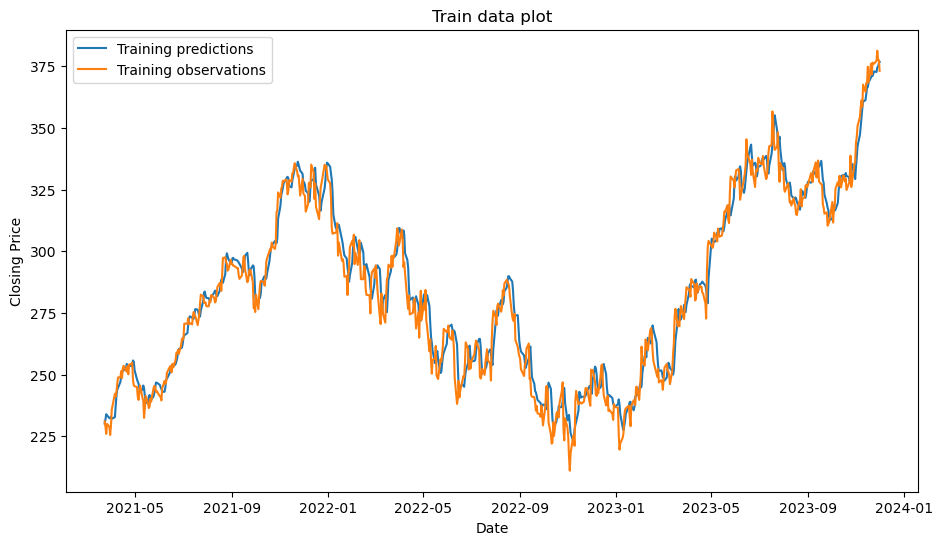

In [28]:
#That went far faster! Let's do the same plots for training, validation, and testing 

training_predictions=model.predict(X_train).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Train data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


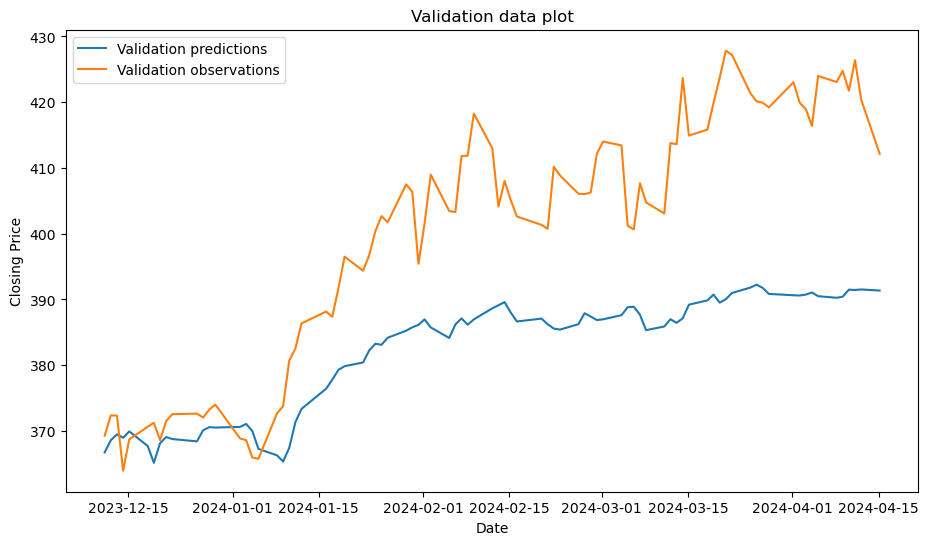

In [41]:
#Validation data set  

validation_predictions=model.predict(X_val).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

#We can see that the predictions somewhat keep up with the reality 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step


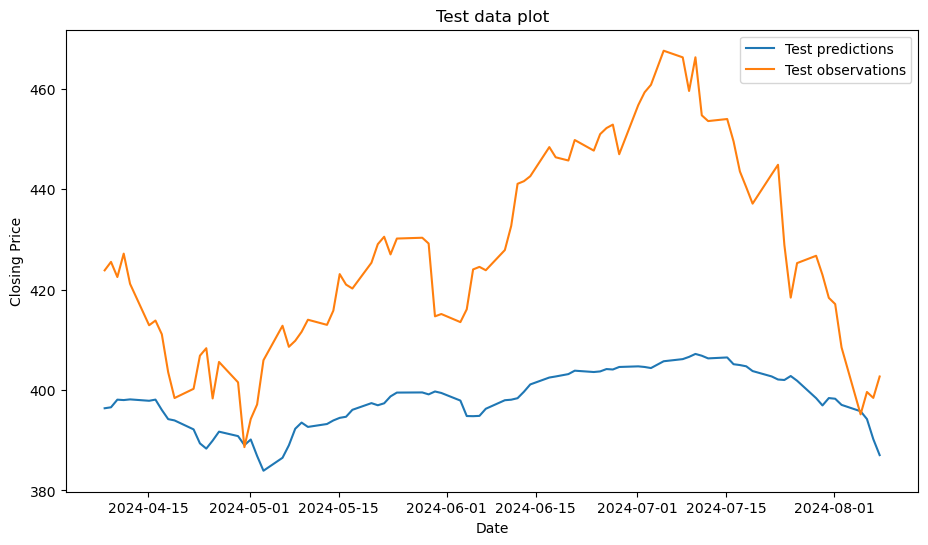

In [30]:
#Testing data set 

test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])

#The predictions for the testing data are not at all reflective of the observations. 
#However, they do portray the overall movement of the stock's closing price.

### Trying to make our model even better: scaling our data's features 

In [74]:
# This model is not very good at predicting stock prices. Let's instead try to scale the data using MinMaxScaler from sklearn

from sklearn.preprocessing import MinMaxScaler 

#Let's go back and get all of our data we used: 
dates = msft_close['Date'].values

#The y array holds all our data labels 
y = msft_close['Close'].values

#The X array holds all our close prices from the three days before for every date. We have to reshape it for the LSTM 
features = msft_close[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']].values
X = features.reshape(len(dates), features.shape[1], 1)

#Our training dataset will be 80% of our data: 
int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80]

#Our validation dataset will be 10% of our dataset (not used for training): 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]

#Our testing data will be the last 10% of the data we have left: 
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

## Now, let's scale the X values: 

scaler = MinMaxScaler()

#MinMaxScaler can only accept 2D objects, so let's reshape X_train and X_test and then scale them 
X_train_2d = X_train.reshape(-1, 1)
X_val_2d=X_val.reshape(-1,1)
X_test_2d=X_test.reshape(-1,1)

X_train_scaled_2d=scaler.fit_transform(X_train_2d)
X_val_scaled_2d=scaler.fit_transform(X_val_2d)
X_test_scaled_2d=scaler.transform(X_test_2d)

#Now, let's reshape them back 

X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_val_scaled = X_val_scaled_2d.reshape(X_val.shape)
X_test_scaled = X_test_scaled_2d.reshape(X_test.shape)

#Now, let's refit our model 

model.fit(X_train_scaled, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.1555 - mean_absolute_error: 0.2490 - val_loss: 12238.8525 - val_mean_absolute_error: 102.3176
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 0.1554 - mean_absolute_error: 0.2573 - val_loss: 12230.8359 - val_mean_absolute_error: 102.2848
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.2108 - mean_absolute_error: 0.3062 - val_loss: 12203.0898 - val_mean_absolute_error: 102.1609
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.1672 - mean_absolute_error: 0.2538 - val_loss: 12164.3867 - val_mean_absolute_error: 101.9834
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.1778 - mean_absolute_error: 0.2703 - val_loss: 12156.8174 - val_mean_absolute_error: 101.9529
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.1909 - mean_absolute_error: 0.2965 - val_loss: 12155.9053 - val_mean_absolute_error: 101.9621
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 74

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


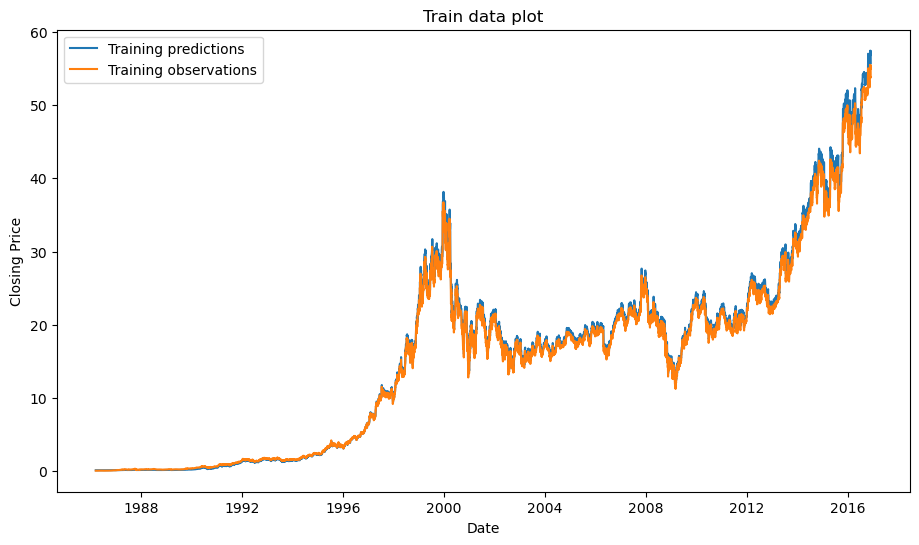

In [76]:
training_predictions=model.predict(X_train_scaled).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Train data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step


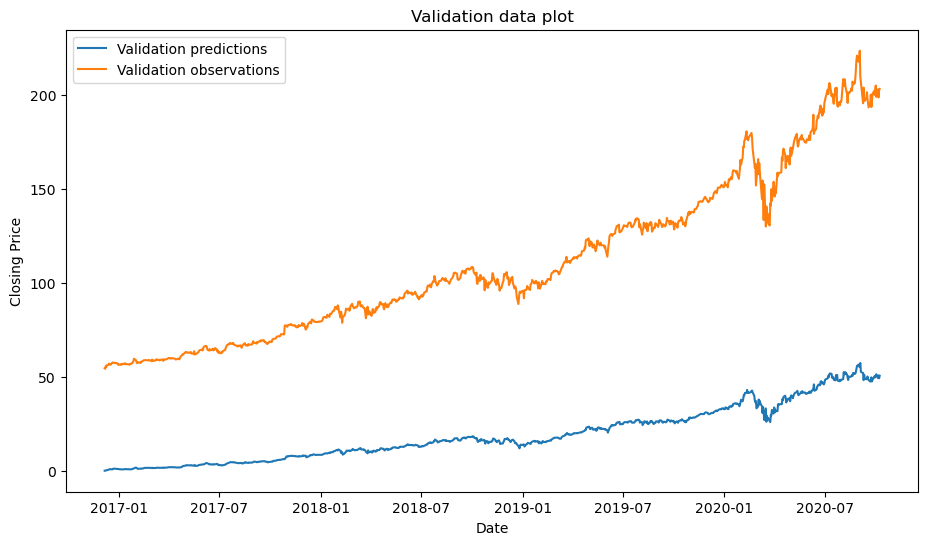

In [78]:
validation_predictions=model.predict(X_val_scaled).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step


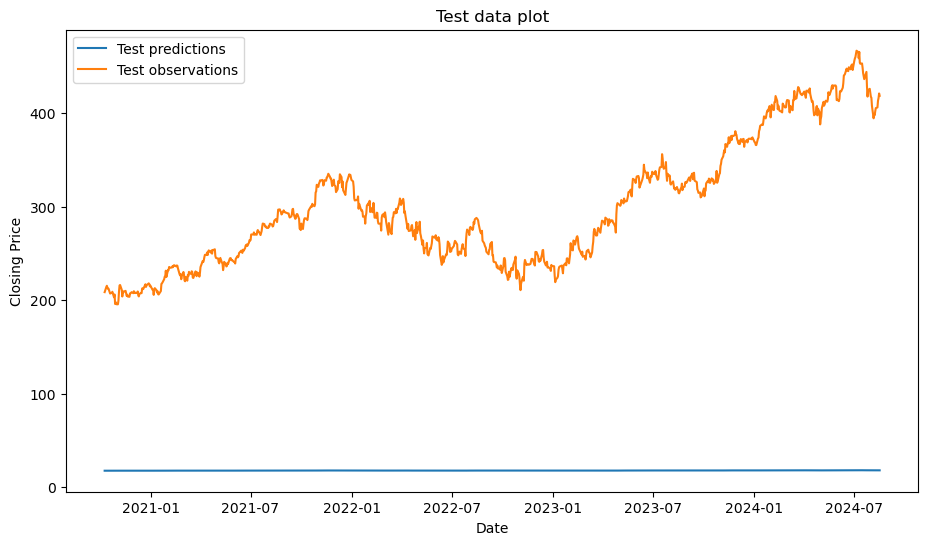

In [80]:
test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])


### Let's mix both of the previous approaches: let's scale the data (using np.log), and use a cutoff date closer to the current date

In [84]:
#Let's go back and get all of our data we used: 

#Let's find an arbitrary cutoff date: 

cutoff_date = pd.Timestamp('2022-03-23').tz_localize('America/New_York') #Make sure my cutoff is the correct datatype 
msft_recent=msft_close[msft_close['Date']>=cutoff_date]

#Let's create arrays (again), but log and X and y arrays 
#The dates give us information to visualize our findings 
dates = msft_recent['Date'].values

#The y array holds all our data labels 
y = np.log(msft_recent['Close']).values

#The X array holds all our close prices from the three days before for every date. We have to reshape it for the LSTM 
features = np.log(msft_recent[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']]).values
X = features.reshape(len(dates), features.shape[1], 1)

#Our training dataset will be 80% of our data: 
int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80]

#Our validation dataset will be 10% of our dataset (not used for training): 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]

#Our testing data will be the last 10% of the data we have left: 
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

In [86]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 412.2621 - mean_absolute_error: 16.5210 - val_loss: 1.1441 - val_mean_absolute_error: 1.0694
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9587 - mean_absolute_error: 0.9623 - val_loss: 0.3110 - val_mean_absolute_error: 0.5573
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0721 - mean_absolute_error: 0.2324 - val_loss: 0.0060 - val_mean_absolute_error: 0.0746
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0321 - mean_absolute_error: 0.1454 - val_loss: 0.1332 - val_mean_absolute_error: 0.3644
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0228 - mean_absolute_error: 0.1194 - val_loss: 0.0541 - val_mean_absolute_error: 0.2317
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0177 - mean_absolute_error: 0.1156 - val_loss: 0.0703 - val_mean_absolute_error: 0.2644
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165 - mean_absolute_error: 0.1091 - val_l

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


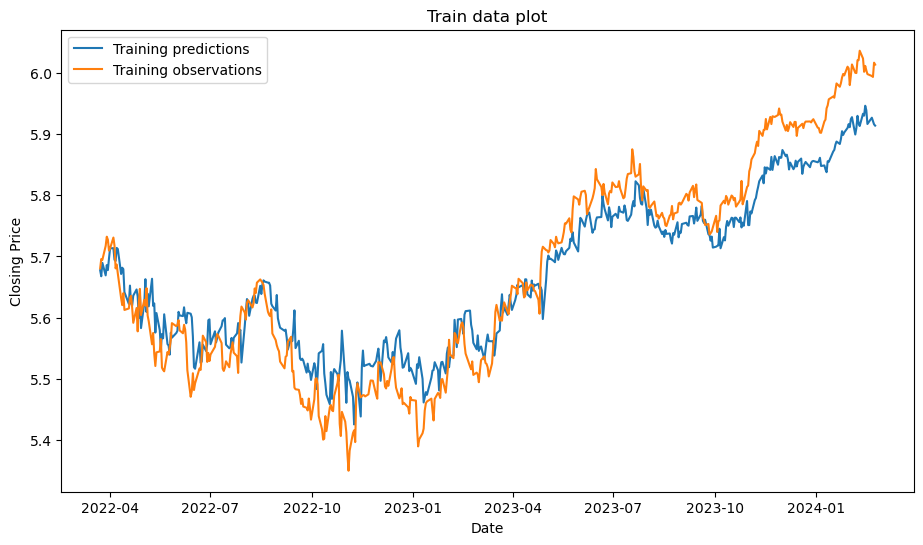

In [88]:
training_predictions=model.predict(X_train).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Train data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


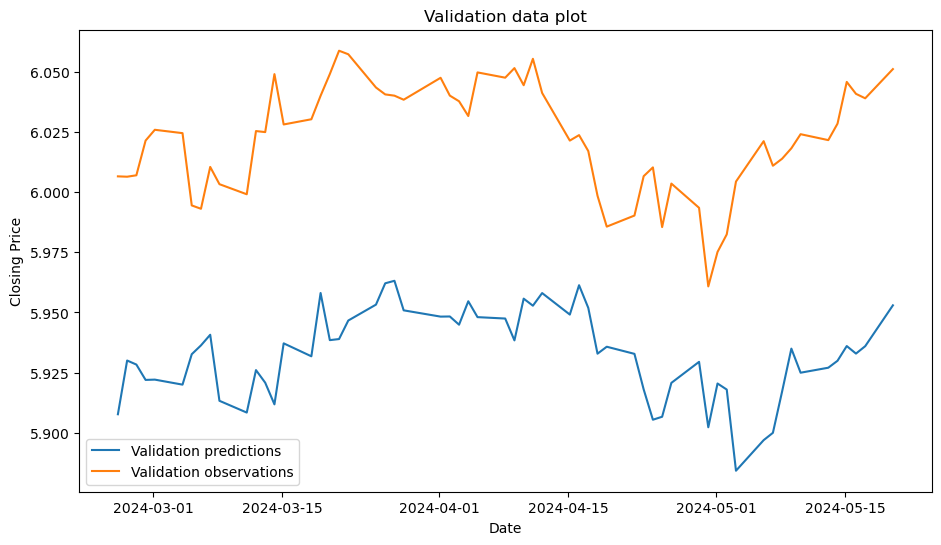

In [90]:
validation_predictions=model.predict(X_val).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


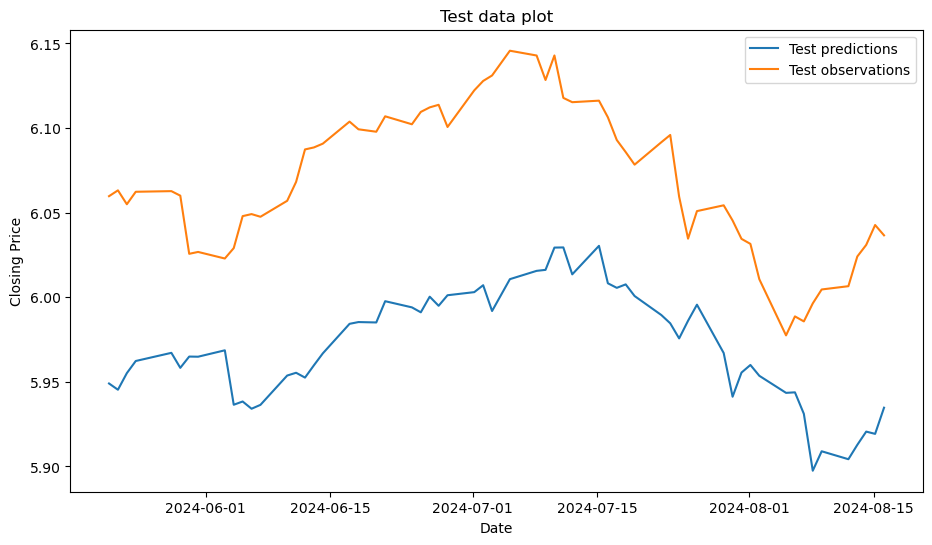

In [92]:
test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])

## We can conclude that our final model: logarithmic scaling and using a shorter time period makes the best model. I will now try this on a different company to see if we can use the same model on a different company.

In [94]:
ticker='AMD'
info=yf.Ticker(ticker)
data=info.history(period='max')
data= data.reset_index()
data_close=data[['Date', 'Close']]

n=3
for i in range (1,n+1): 
    data_close[f'Close_{i}_days_ago'] = data_close['Close'].shift(i)
data_close.dropna(inplace=True)

cutoff_date = pd.Timestamp('2022-03-23').tz_localize('America/New_York') 
data_recent=data_close[data_close['Date']>=cutoff_date]

dates = data_recent['Date'].values
y = np.log(data_recent['Close']).values
features = np.log(data_recent[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']]).values
X = features.reshape(len(dates), features.shape[1], 1)

int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80] 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)



Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1595 - mean_absolute_error: 0.3407 - val_loss: 0.2858 - val_mean_absolute_error: 0.5302
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0626 - mean_absolute_error: 0.2077 - val_loss: 0.0587 - val_mean_absolute_error: 0.2324
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0342 - mean_absolute_error: 0.1465 - val_loss: 0.1175 - val_mean_absolute_error: 0.3361
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0298 - mean_absolute_error: 0.1383 - val_loss: 0.0810 - val_mean_absolute_error: 0.2767
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0312 - mean_absolute_error: 0.1426 - val_loss: 0.0739 - val_mean_absolute_error: 0.2638
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0270 - mean_absolute_error: 0.1312 - val_loss: 0.0760 - val_mean_absolute_error: 0.2679
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0253 - mean_absolute_error: 0.1297 - val_loss

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step


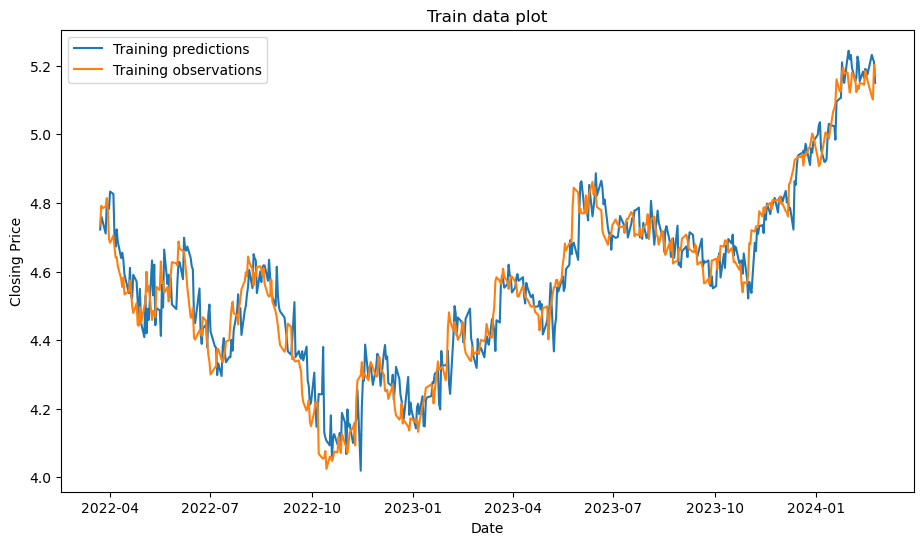

In [96]:
training_predictions=model.predict(X_train).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Train data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


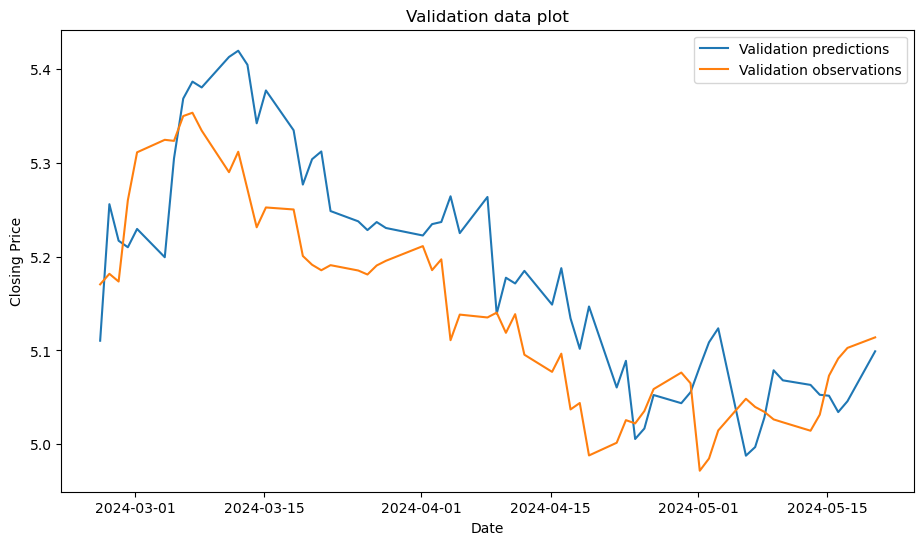

In [98]:
validation_predictions=model.predict(X_val).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


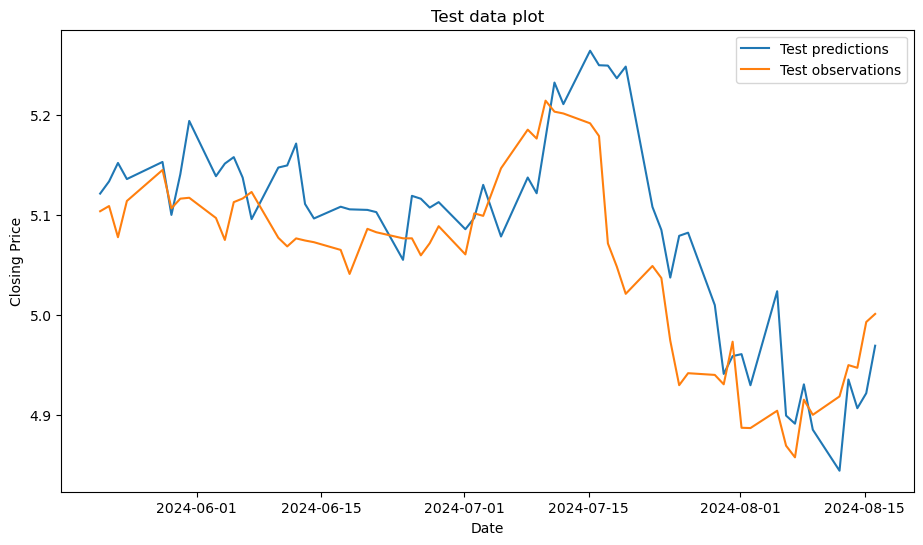

In [100]:
test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])

In [102]:
#Let's evaluate these using empirical methods now! 

from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error

print('Root MSE: ' ,root_mean_squared_error(test_predictions, y_test))
print('MSE: ', mean_squared_error(test_predictions, y_test))
print('MAE: ', mean_absolute_error(test_predictions, y_test))

Root MSE:  0.07007207253290994
MSE:  0.00491009534905739
MAE:  0.05356019768287165


## We can see that this model works well for AMD as well, and it should work for other companies also. Success!

### Let's try and predict future prices from this model now

In [104]:
# Predict future prices
n_future_steps = 10
last_known_data = X[-1]  # Use the last known input sequence

predicted_prices = []

for _ in range(n_future_steps):
    # Predict the next price
    next_price = model.predict(last_known_data.reshape(1, last_known_data.shape[0], last_known_data.shape[1]))
    predicted_prices.append(next_price[0, 0])
    
    # Update the input sequence
    last_known_data = np.roll(last_known_data, shift=-1, axis=0)
    last_known_data[-1] = next_price

# Convert predictions back from log scale
predicted_prices = np.exp(predicted_prices)

# Generate future dates
last_date = pd.Timestamp(data_recent['Date'].max()).to_pydatetime()
future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, n_future_steps + 1)]

# Create DataFrame for future predictions
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': predicted_prices
})

future_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,Date,Predicted_Close
0,2024-08-17 00:00:00-04:00,143.899857
1,2024-08-18 00:00:00-04:00,147.697220
2,2024-08-19 00:00:00-04:00,152.240738
3,2024-08-20 00:00:00-04:00,157.555801
4,2024-08-21 00:00:00-04:00,163.769775
5,2024-08-22 00:00:00-04:00,171.061905
6,2024-08-23 00:00:00-04:00,179.656082
7,2024-08-24 00:00:00-04:00,189.823593
8,2024-08-25 00:00:00-04:00,201.887222
9,2024-08-26 00:00:00-04:00,216.222504


Text(0, 0.5, 'Predicted Closing Price')

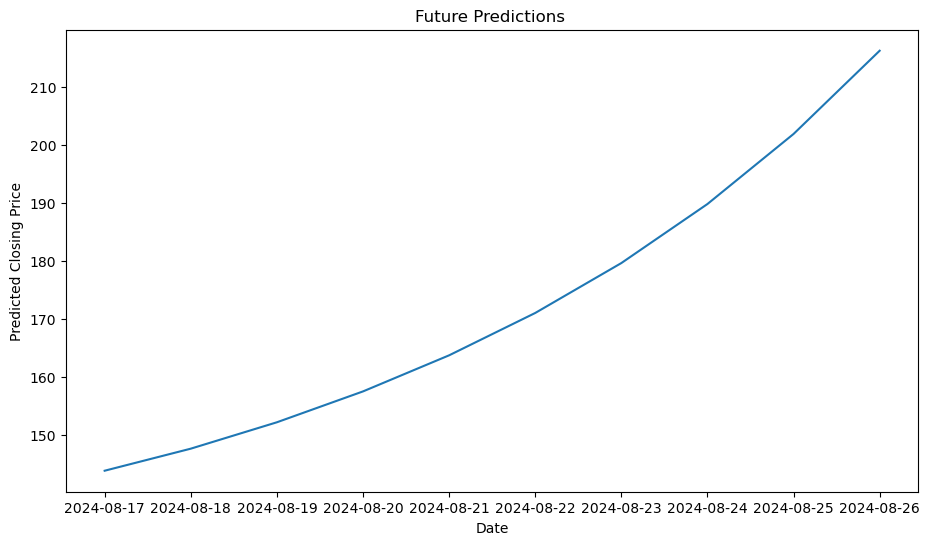

In [106]:
plt.figure(figsize=(11,6))
plt.plot(future_predictions['Date'], future_predictions['Predicted_Close'])
plt.title('Future Predictions ')
plt.xlabel('Date')
plt.ylabel('Predicted Closing Price')

## Let's test this on other companies as well, using a more randomized method!

In [108]:
# To test our model on other companies to see if it does well, let's try it on a list of companies from the s&p 500

#Gathering the list of tickers 
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
table = pd.read_html(url)[0]
sp500_tickers = table["Symbol"].tolist()
sp500_tickers

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BK',
 'BBWI',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'BA',
 'BKNG',
 'BWA',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BLDR',
 'BG',
 'BXP',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CHRW',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CAG'

In [114]:
#Testing the model on that many companies is not possible with my computing power, 
#so let's take a random sample of 5 stocks from the list and test the model using them  

import random 
random_stocks = random.sample(sp500_tickers, 5)


In [137]:
# Applying the model to our list of tickers from the S&P 500 

root_mse=[]
avg_price=[]
for i in random_stocks: 
    info=yf.Ticker(i)
    data=info.history(period='max')
    data= data.reset_index()
    data_close=data[['Date', 'Close']]
    avgprice=np.mean(data_close['Close'])
    avg_price.append(avgprice)
    n=3
    for m in range (1,n+1): 
        data_close[f'Close_{m}_days_ago'] = data_close['Close'].shift(m)
    data_close.dropna(inplace=True)
    cutoff_date = pd.Timestamp('2022-03-23').tz_localize('America/New_York') 
    data_recent=data_close[data_close['Date']>=cutoff_date]
    dates = data_recent['Date'].values
    y = np.log(data_recent['Close']).values
    features = np.log(data_recent[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']]).values
    X = features.reshape(len(dates), features.shape[1], 1)
    int80=int(len(dates) * 0.8)
    dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80] 
    int90=int(len(dates) * 0.9)
    dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]
    dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
    test_predictions=model.predict(X_test).flatten()
    print('For', i, ', these are the evaluation statistics')
    print('Root MSE: ' ,root_mean_squared_error(test_predictions, y_test))
    print('MSE: ', mean_squared_error(test_predictions, y_test))
    print('MAE: ', mean_absolute_error(test_predictions, y_test))
    root_mse.append(root_mean_squared_error(test_predictions, y_test))



Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0392 - mean_absolute_error: 0.1698 - val_loss: 0.0050 - val_mean_absolute_error: 0.0652
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095 - mean_absolute_error: 0.0815 - val_loss: 0.0038 - val_mean_absolute_error: 0.0561
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - mean_absolute_error: 0.0471 - val_loss: 0.0067 - val_mean_absolute_error: 0.0779
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - mean_absolute_error: 0.0355 - val_loss: 0.0052 - val_mean_absolute_error: 0.0681
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0021 - val_mean_absolute_error: 0.0392
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2152e-04 - mean_absolute_error: 0.0239 - val_loss: 0.0040 - val_mean_absolute_error: 0.0586
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - mean_absolute_error: 0.0260 - val_

In [139]:
#Let's find the average error of this model: 

total=np.sum(root_mse)
length=len(root_mse)
average_error=total/length

print('The average error of this model when used for 5 random S&P 500 companies gives us an RSME of', average_error)

The average error of this model when used for 5 random S&P 500 companies gives us an RSME of 0.021052811280919063


In [156]:
#Let's compare this to our actual average price of these 5 random companies, to see if this RSME is relatively good. 
#This is called MAPE, or mean absolute percentage error 

total_error=0
for i in range (0, len(avg_price)): 
    percentage_error=(root_mse[i]/avg_price[i])*100
    total_error=total_error+percentage_error 
    avg_percentage_error=total_error/len(avg_price)

print('The average percentage error of this model is', avg_percentage_error, '%')
    

The average percentage error of this model is 0.11075232133692006 %


### Thus, we can conclude that this model does quite well, and gives us an average root mean square error of only ~0.029, with a % error of only 0.11% relative to each company's average stock price! Hence, this model does a pretty good job of predicting stock prices.